In [1]:
!pip install d2l

In [2]:
import collections
import math
import tensorflow as tf
from d2l import tensorflow as d2l

In [3]:
# Encoder without d2l dependency
class Seq2SeqEncoder(tf.keras.layers.Layer):
    """The RNN encoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        super().__init__(**kwargs)
        # Embedding layer
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_size)
        self.rnn = tf.keras.layers.RNN(tf.keras.layers.StackedRNNCells(
            [tf.keras.layers.GRUCell(num_hiddens, dropout=dropout)
             for _ in range(num_layers)]), return_sequences=True,
                                       return_state=True)

    def call(self, X, *args, **kwargs):
        # The input `X` shape: (`batch_size`, `num_steps`)
        # The output `X` shape: (`batch_size`, `num_steps`, `embed_size`)
        X = self.embedding(X)
        output = self.rnn(X, **kwargs)
        state = output[1:]
        return output[0], state

In [4]:
# Decoder without d2l dependency
class Seq2SeqDecoder(tf.keras.layers.Layer):
    """The RNN decoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super().__init__(**kwargs)
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_size)
        self.rnn = tf.keras.layers.RNN(tf.keras.layers.StackedRNNCells(
            [tf.keras.layers.GRUCell(num_hiddens, dropout=dropout)
             for _ in range(num_layers)]), return_sequences=True,
                                       return_state=True)
        self.dense = tf.keras.layers.Dense(vocab_size)

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]  # Updated this line

    def call(self, X, state, **kwargs):
        # The output `X` shape: (`batch_size`, `num_steps`, `embed_size`)
        X = self.embedding(X)
        # Broadcast `context` so it has the same `num_steps` as `X`
        context = tf.repeat(tf.expand_dims(state[-1], axis=1), repeats=X.shape[1], axis=1)
        X_and_context = tf.concat((X, context), axis=2)
        rnn_output = self.rnn(X_and_context, state, **kwargs)
        output = self.dense(rnn_output[0])
        # `output` shape: (`batch_size`, `num_steps`, `vocab_size`)
        # `state` is a list with `num_layers` entries. Each entry has shape:
        # (`batch_size`, `num_hiddens`)
        return output, rnn_output[1:]

In [5]:
# These functions were left the same as d2l, did not update
def sequence_mask(X, valid_len, value=0):
    """Mask irrelevant entries in sequences."""
    maxlen = X.shape[1]
    mask = tf.range(start=0, limit=maxlen, dtype=tf.float32)[
        None, :] < tf.cast(valid_len[:, None], dtype=tf.float32)

    if len(X.shape) == 3:
        return tf.where(tf.expand_dims(mask, axis=-1), X, value)
    else:
        return tf.where(mask, X, value)

X = tf.constant([[1, 2, 3], [4, 5, 6]])
sequence_mask(X, tf.constant([1, 2]))

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 0, 0],
       [4, 5, 0]], dtype=int32)>

In [6]:
# These functions were left the same as d2l
class MaskedSoftmaxCELoss(tf.keras.losses.Loss):
    """The softmax cross-entropy loss with masks."""
    def __init__(self, valid_len):
        super().__init__(reduction='none')
        self.valid_len = valid_len

    # `pred` shape: (`batch_size`, `num_steps`, `vocab_size`)
    # `label` shape: (`batch_size`, `num_steps`)
    # `valid_len` shape: (`batch_size`,)
    def call(self, label, pred):
        weights = tf.ones_like(label, dtype=tf.float32)
        weights = sequence_mask(weights, self.valid_len)
        label_one_hot = tf.one_hot(label, depth=pred.shape[-1])
        unweighted_loss = tf.keras.losses.CategoricalCrossentropy(
            from_logits=True, reduction='none')(label_one_hot, pred)
        weighted_loss = tf.reduce_mean((unweighted_loss*weights), axis=1)
        return weighted_loss

In [10]:
# Functions for removing d2l dependency in train_seq2seq
import time
import matplotlib.pyplot as plt
class Accumulator:
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def grad_clipping(grads, theta):
    """Clip gradients."""
    total_norm = 0
    for grad in grads:
        if grad is not None:
            grad_squared = tf.square(grad) if isinstance(grad, tf.Tensor) else tf.square(grad.values)
            total_norm += tf.reduce_sum(grad_squared)
    total_norm = tf.sqrt(total_norm)
    if total_norm < theta:
        return grads
    else:
        clipped_grads = []
        for grad in grads:
            if grad is not None:
                if isinstance(grad, tf.Tensor):
                    clipped_grads.append(grad * theta / total_norm)
                else:
                    # IndexedSlices
                    clipped_values = grad.values * theta / total_norm
                    clipped_grads.append(tf.IndexedSlices(clipped_values, grad.indices, grad.dense_shape))
            else:
                clipped_grads.append(None)
        return clipped_grads


In [11]:
# Train_seq2seq without d2l dependency while ploting every epoch
from IPython.display import clear_output
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """Train a model for sequence to sequence."""
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    loss_history = []
    for epoch in range(num_epochs):
        start_time = time.time()
        metric = Accumulator(2)  # Sum of training loss, no. of tokens
        for batch in data_iter:
            X, X_valid_len, Y, Y_valid_len = [x for x in batch]
            bos = tf.reshape(tf.constant([tgt_vocab['<bos>']] * Y.shape[0]),
                             shape=(-1, 1))
            dec_input = tf.concat([bos, Y[:, :-1]], 1)  # Teacher forcing
            with tf.GradientTape() as tape:
                Y_hat, _ = net(X, dec_input, X_valid_len, training=True)
                l = MaskedSoftmaxCELoss(Y_valid_len)(Y, Y_hat)
            gradients = tape.gradient(l, net.trainable_variables)
            gradients = grad_clipping(gradients, 1)
            optimizer.apply_gradients(zip(gradients, net.trainable_variables))
            num_tokens = tf.reduce_sum(Y_valid_len).numpy()
            metric.add(tf.reduce_sum(l), num_tokens)
        loss = metric[0] / metric[1]
        loss_history.append(loss)

        # Clear previous plot and plot the updated loss history
        clear_output(wait=True)
        plt.plot(loss_history, label="Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

        print(f'Epoch {epoch + 1}, Loss: {loss:.3f}, Time: {time.time() - start_time:.2f} sec')

    print(f'Final loss {metric[0] / metric[1]:.3f}, {metric[1] / (time.time() - start_time):.1f} '
          f'tokens/sec on {str(device)}')


In [12]:
class EncoderDecoder(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, src_array, tgt_array, src_valid_len, training=False, **kwargs):
        enc_outputs = self.encoder(src_array, training=training)
        dec_state = self.decoder.init_state(enc_outputs, src_valid_len)
        return self.decoder(tgt_array, dec_state, training=training, **kwargs)


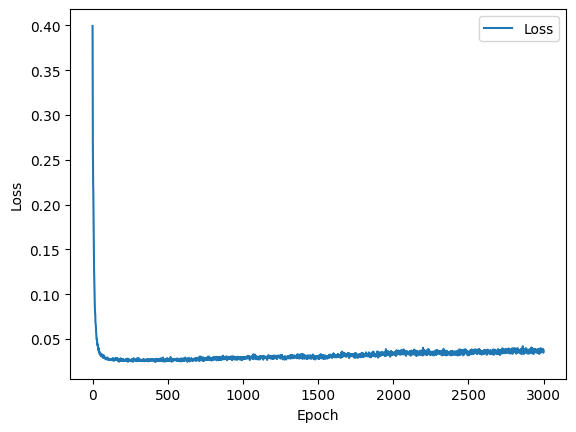

Epoch 3000, Loss: 0.037, Time: 3.96 sec
Final loss 0.037, 642.1 tokens/sec on <tensorflow.python.eager.context._EagerDeviceContext object at 0x7c14ac822c80>


In [24]:
# embedding size of 3000 seems resonable, 256 hidden units, 3 layers, 0.3 dropout
embed_size, num_hiddens, num_layers, dropout = 300, 256, 3, 0.3
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 3000, d2l.try_gpu()
train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

encoder = Seq2SeqEncoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

## Initially, the loss was 0.026 after 300 epochs. The loss increased to 0.037 after 3000 epochs.


In [21]:
# These functions were left the same as d2l
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    save_attention_weights=False):
    """Predict for sequence to sequence."""
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']]
    enc_valid_len = tf.constant([len(src_tokens)])
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    # Add the batch axis
    enc_X = tf.expand_dims(src_tokens, axis=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len, training=False)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    # Add the batch axis
    dec_X = tf.expand_dims(tf.constant([tgt_vocab['<bos>']]), axis=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state, training=False)
        # We use the token with the highest prediction likelihood as the input
        # of the decoder at the next time step
        dec_X = tf.argmax(Y, axis=2)
        pred = tf.squeeze(dec_X, axis=0)
        # Save attention weights
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # Once the end-of-sequence token is predicted, the generation of the
        # output sequence is complete
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred.numpy())
    return ' '.join(tgt_vocab.to_tokens(tf.reshape(output_seq, shape = -1).numpy().tolist())), attention_weight_seq


# BLEU score
def bleu(pred_seq, label_seq, k):
    """Compute the BLEU."""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In [25]:
engs = ['hello .','go .', "i lost .", 'he\'s calm .', 'i\'m home .', 'are you ok ?', 'please help .', 'this is fun .', 'good luck !']
fras = ['bonjour .','va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .', 'tu vas bien ?', 'aidez-moi s\'il vous plaît .', 'c\'est amusant .', 'bonne chance !']

for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')


hello . => <unk> ., bleu 0.000
go . => va !, bleu 1.000
i lost . => j'ai perdu ., bleu 1.000
he's calm . => il est paresseux ., bleu 0.658
i'm home . => je suis chez moi <unk> ., bleu 0.803
are you ok ? => qui <unk> ?, bleu 0.000
please help . => <unk> !, bleu 0.000
this is fun . => tiens ça !, bleu 0.000
good luck ! => bon boulot !, bleu 0.000


This model is not good based on the BLEU score

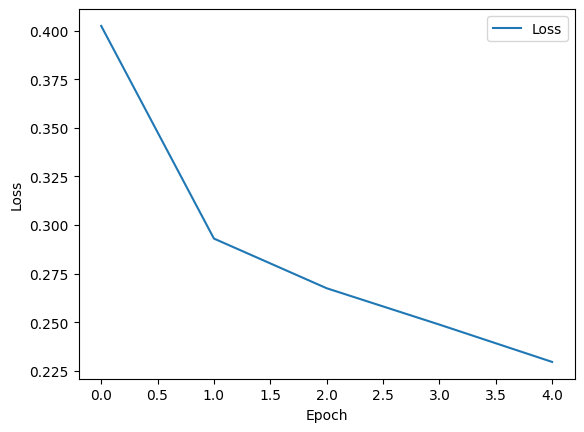

Epoch 5, Loss: 0.230, Time: 4.40 sec
Final loss 0.230, 577.5 tokens/sec on <tensorflow.python.eager.context._EagerDeviceContext object at 0x7c14ac8a42c0>


In [19]:
# embedding size of 300 seems resonable, 256 hidden units, 3 layers, 0.3 dropout
embed_size, num_hiddens, num_layers, dropout = 300, 256, 3, 0.30
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 5, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net_d2l = EncoderDecoder(encoder, decoder)
train_seq2seq(net_d2l, train_iter, lr, num_epochs, tgt_vocab, device)

In [26]:
engs = ['hello .','go .', "i lost .", 'he\'s calm .', 'i\'m home .', 'are you ok ?', 'please help .', 'this is fun .', 'good luck !']
fras = ['bonjour .','va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .', 'tu vas bien ?', 'aidez-moi s\'il vous plaît .', 'c\'est amusant .', 'bonne chance !']
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(
        net_d2l, eng, src_vocab, tgt_vocab, num_steps)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

hello . => <unk> !, bleu 0.000
go . => <unk> !, bleu 0.000
i lost . => je suis <unk> ., bleu 0.000
he's calm . => je suis <unk> ., bleu 0.000
i'm home . => je suis <unk> ., bleu 0.512
are you ok ? => <unk> tom ., bleu 0.000
please help . => <unk> !, bleu 0.000
this is fun . => <unk> <unk>, bleu 0.000
good luck ! => <unk> !, bleu 0.000
